In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:

from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0
Compute dtype: float16
Variable dtype: float32


In [4]:
import omegaconf
import numpy as np
import matplotlib.pyplot as plt
from ganime.data.experimental import ImageDataset, VideoDataset
from ganime.model.vqgan_clean.vqgan import VQGAN
from ganime.visualization.videos import display_videos
from ganime.visualization.images import display_images
from ganime.model.vqgan_clean.transformer.mingpt import GPT
import tensorflow as tf
from datetime import datetime
from tqdm import tqdm
import os
from pyprojroot.pyprojroot import here
#tf.get_logger().setLevel('ERROR')

In [5]:
for device in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(device, True)

In [6]:
num_workers = len(tf.config.list_physical_devices("GPU"))
batch_size = 256

In [7]:
cfg = omegaconf.OmegaConf.load(here("configs/moving_mnist_image.yaml"))

In [8]:
dataset_length = 20*10000
num_batch = dataset_length / batch_size

In [9]:
def preprocess(element):
    element = tf.reshape(element, (tf.shape(element)[0], tf.shape(element)[1], 3))
    element = tf.cast(element, tf.float32) / 255.0
    return element, element

In [10]:
dataset = ImageDataset("../../../data/mnist_tfrecords").load()
dataset = dataset.shuffle(dataset_length, reshuffle_each_iteration=True).map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

2022-06-08 10:16:53.879113: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-08 10:16:56.480061: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14252 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-06-08 10:16:56.481373: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14252 MB memory:  -> device: 1, name: NVIDIA RTX A4000, pci bus id: 0000:25:00.0, compute capability: 8.6
2022-06-08 10:16:56.482285: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 w

In [11]:
train_size = int(num_batch * 0.8)
validation_size = int(num_batch * 0.1)
test_size = int(num_batch * 0.1)

In [12]:
train_ds = dataset.take(train_size)
validation_ds = dataset.skip(train_size).take(validation_size)
test_ds = dataset.skip(train_size + validation_size).take(validation_size)

In [13]:
train_sample_data = next(train_ds.as_numpy_iterator())
validation_sample_data = next(validation_ds.as_numpy_iterator())

In [14]:
from ganime.utils.callbacks import TensorboardImage, get_logdir

logdir = get_logdir("../../../logs/ganime/", experiment_name="moving_mnist_image_f16")
# Define the basic TensorBoard callback.
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
tensorboard_image_callback = TensorboardImage(logdir, train_sample_data, validation_sample_data)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_total_loss",
    min_delta=0.0001,
    patience=100,
    restore_best_weights=True,
)
checkpointing = tf.keras.callbacks.ModelCheckpoint(os.path.join(logdir, "checkpoint", "checkpoint"), monitor='val_total_loss', save_best_only=True, save_weights_only=True)
callbacks = [tensorboard_callback, tensorboard_image_callback, early_stopping, checkpointing]

In [15]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')


In [16]:
# train_mean, train_var, train_std = dataset_statistics(train_ds)

In [17]:
from ganime.visualization.images import display_true_pred

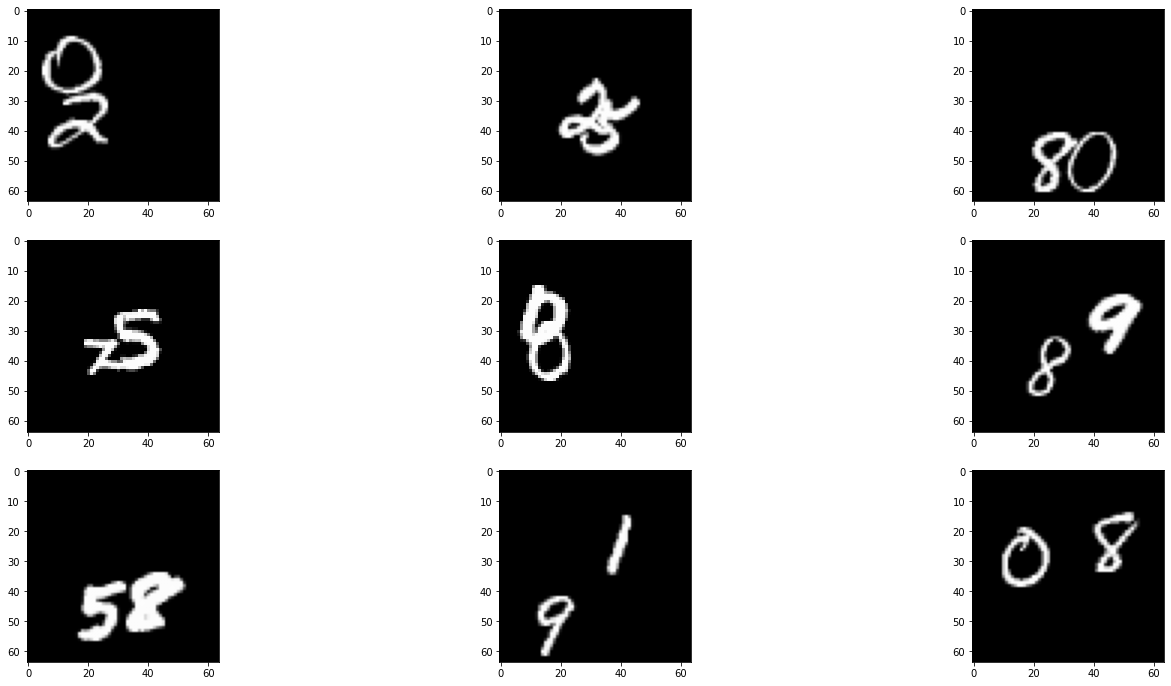

In [18]:
display_images(train_sample_data[0])
plt.show()

In [19]:
with strategy.scope():
    vqgan = VQGAN(**cfg["model"])

Working with z of shape (1, 128, 16, 16) = 32768 dimensions.


2022-06-08 10:17:09.197271: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


VQLPIPSWithDiscriminator running with hinge loss.
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/repl

In [20]:
with strategy.scope():
    gen_optimizer = mixed_precision.LossScaleOptimizer(tf.keras.optimizers.Adam(learning_rate=1e-3))#, clipvalue=1.0, clipnorm=0.5, epsilon=1e-4))
    disc_optimizer = mixed_precision.LossScaleOptimizer(tf.keras.optimizers.Adam(learning_rate=5e-5))#, clipvalue=1.0, clipnorm=0.5, epsilon=1e-4))
    vqgan.compile(gen_optimizer=gen_optimizer, disc_optimizer=disc_optimizer)

In [21]:
history = vqgan.fit(train_ds, validation_data=validation_ds, epochs=1500, callbacks=callbacks)

Epoch 1/1500
INFO:tensorflow:batch_all_reduce: 201 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 13 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 201 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 13 all-reduces with algorithm = nccl, num_packs = 1


2022-06-08 10:22:31.748737: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-06-08 10:22:32.670072: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-06-08 10:22:33.759404: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-06-08 10:22:34.764523: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-06-08 10:22:35.637367: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-06-08 10:22:36.620254: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-06-08 10:22:36.833253: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-06-08 10:22:38.905410: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


625/625 [==============================] - 619s 431ms/step - total_loss: 12.8043 - reconstruction_loss: 12.3784 - vq_loss: 0.4259 - disc_loss: 0.0000e+00 - val_total_loss: 11.3069 - val_reconstruction_loss: 11.2875 - val_vq_loss: 0.0194 - val_disc_loss: 0.0000e+00
Epoch 2/1500
625/625 [==============================] - 180s 283ms/step - total_loss: 11.2624 - reconstruction_loss: 11.2499 - vq_loss: 0.0125 - disc_loss: 0.0000e+00 - val_total_loss: 11.2464 - val_reconstruction_loss: 11.2381 - val_vq_loss: 0.0083 - val_disc_loss: 0.0000e+00
Epoch 3/1500
625/625 [==============================] - 182s 283ms/step - total_loss: 11.2423 - reconstruction_loss: 11.2359 - vq_loss: 0.0064 - disc_loss: 0.0000e+00 - val_total_loss: 11.2291 - val_reconstruction_loss: 11.2242 - val_vq_loss: 0.0049 - val_disc_loss: 0.0000e+00
Epoch 4/1500
625/625 [==============================] - 181s 284ms/step - total_loss: 11.2332 - reconstruction_loss: 11.2293 - vq_loss: 0.0039 - disc_loss: 0.0000e+00 - val_total_

In [ ]:
x = train_ds[5][0]
generated = vqgan(x[:10])

In [ ]:
display_images(generated)
plt.show()

In [ ]:
display_images(x)
plt.show()

In [ ]:
x2 = train_ds[30][0]
generated2 = vqgan(x2[:10])

In [ ]:
display_images(generated2)
plt.show()

In [ ]:
display_images(x2)
plt.show()